In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import statsmodels.api as smf

In [41]:
airline = pd.read_csv("Airlines+Data (3).csv")

In [39]:
airline.head(10).T

,0,1,2,3,4,5,6,7,8,9
Month,Jan-95,Feb-95,Mar-95,Apr-95,May-95,Jun-95,Jul-95,Aug-95,Sep-95,Oct-95
Passengers,112,118,132,129,121,135,148,148,136,119


## EDA & Preprocessing

In [29]:
airline.info

<bound method DataFrame.info of      Month  Passengers
0   Jan-95         112
1   Feb-95         118
2   Mar-95         132
3   Apr-95         129
4   May-95         121
..     ...         ...
91  Aug-02         405
92  Sep-02         355
93  Oct-02         306
94  Nov-02         271
95  Dec-02         306

[96 rows x 2 columns]>

In [30]:
airline.isnull().sum()

Month         0
Passengers    0
dtype: int64

In [31]:
airline.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,96.0,213.708333,71.918216,104.0,156.0,200.0,264.75,413.0


<AxesSubplot:xlabel='Month', ylabel='Passengers'>

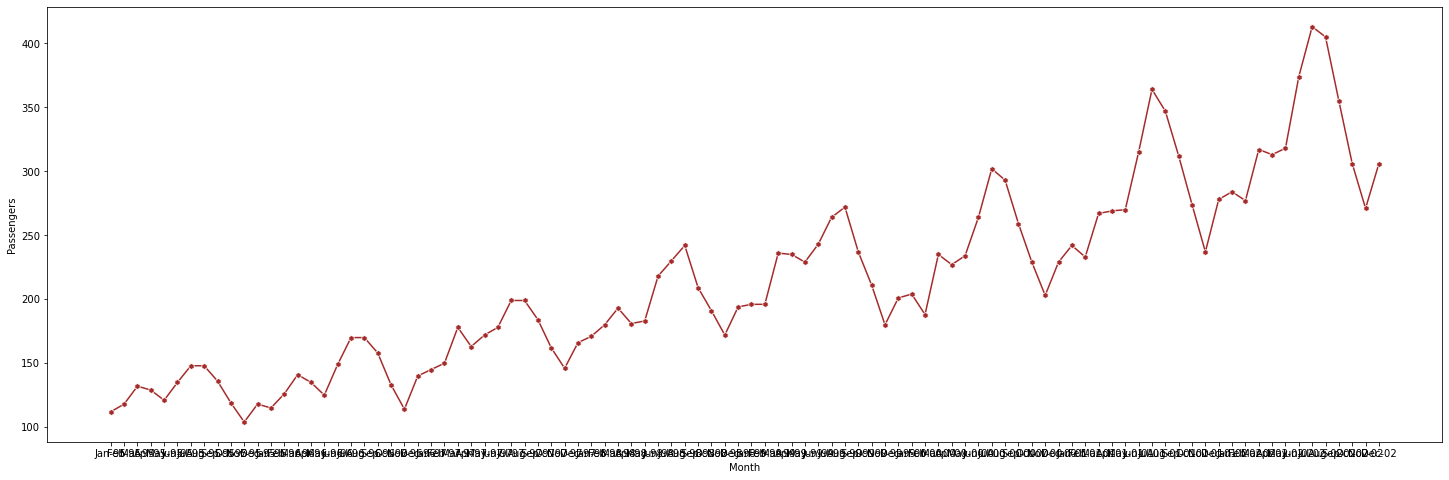

In [32]:
fig, ax = plt.subplots(figsize=(25, 8))
sns.lineplot(x = "Month",y = "Passengers", data = airline, color = "brown", marker = "h")

Upward Linear Trend with muliplicative seasonality

C:\Users\shrin\AppData\Local\Temp/ipykernel_9904/2606136497.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  seasonal_ts_add=smf.tsa.seasonal_decompose(airline["Passengers"],freq=11)


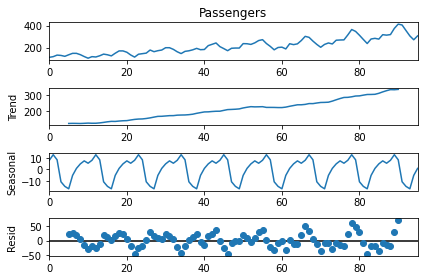

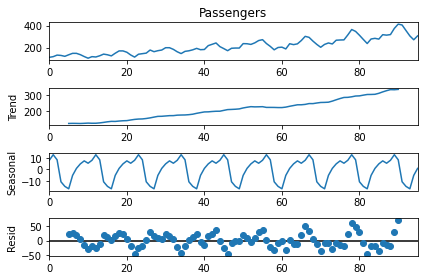

In [33]:
seasonal_ts_add=smf.tsa.seasonal_decompose(airline["Passengers"],freq=11)
seasonal_ts_add.plot()

In [42]:
airline['Month'] = pd.to_datetime(airline['Month'])
airline['Months'] = airline['Month'].dt.strftime('%b')
airline.head()

,Month,Passengers,Months
0,1995-01-01,112,Jan
1,1995-02-01,118,Feb
2,1995-03-01,132,Mar
3,1995-04-01,129,Apr
4,1995-05-01,121,May


<AxesSubplot:>

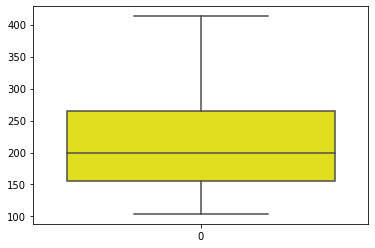

In [43]:
sns.boxplot(data=airline['Passengers'],color='yellow')

In [47]:
month_dummies = pd.DataFrame(pd.get_dummies(airline['Months']))
airline1 = pd.concat([airline,month_dummies],axis = 1)
airline1.head()

,Month,Passengers,Months,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1995-01-01,112,Jan,0,0,0,0,1,0,0,0,0,0,0,0
1,1995-02-01,118,Feb,0,0,0,1,0,0,0,0,0,0,0,0
2,1995-03-01,132,Mar,0,0,0,0,0,0,0,1,0,0,0,0
3,1995-04-01,129,Apr,1,0,0,0,0,0,0,0,0,0,0,0
4,1995-05-01,121,May,0,0,0,0,0,0,0,0,1,0,0,0


In [50]:
airline1["t"] = np.arange(1,97)
airline1["t_squared"] = airline1["t"]*airline1["t"]
airline1["log_Passengers"] = np.log(airline1["Passengers"])
airline1.columns
airline1.head()

,Month,Passengers,Months,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,t,t_squared,log_Passengers
0,1995-01-01,112,Jan,0,0,0,0,1,0,0,0,0,0,0,0,1,1,4.718499
1,1995-02-01,118,Feb,0,0,0,1,0,0,0,0,0,0,0,0,2,4,4.770685
2,1995-03-01,132,Mar,0,0,0,0,0,0,0,1,0,0,0,0,3,9,4.882802
3,1995-04-01,129,Apr,1,0,0,0,0,0,0,0,0,0,0,0,4,16,4.859812
4,1995-05-01,121,May,0,0,0,0,0,0,0,0,1,0,0,0,5,25,4.795791


In [51]:
Train = airline1.head(75)
Test = airline1.tail(25)

## Model Building

In [52]:
import statsmodels.formula.api as smf 

linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_linear))**2))
print("RMSE Linear: ",rmse_linear)

RMSE Linear:  51.83809749584507


In [53]:
Exp = smf.ols('log_Passengers~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Exp)))**2))
print("RMSE Exponential: ",rmse_Exp)

RMSE Exponential:  42.775259750198


In [54]:
Quad = smf.ols('Passengers~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_Quad))**2))
print("RMSE Quadratic: ",rmse_Quad)

RMSE Quadratic:  54.03140645625428


In [55]:
add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea))**2))
print("RMSE Additive seasonality: ",rmse_add_sea)

RMSE Additive seasonality:  123.0276378808424


In [56]:
add_sea_Quad = smf.ols('Passengers~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea_quad))**2))
print("RMSE Additive Seasonality Quadratic:",rmse_add_sea_quad )

RMSE Additive Seasonality Quadratic: 36.536274445464215


In [57]:
Mul_sea = smf.ols('log_Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
print("RMSE Multiplicative Seasonality:",rmse_Mult_sea)

RMSE Multiplicative Seasonality: 128.16622817596138


In [58]:
Mul_Add_sea = smf.ols('log_Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
print("RMSE Multiplicative Additive Seasonality:",rmse_Mult_add_sea )

RMSE Multiplicative Additive Seasonality: 11.565825437685964


In [59]:
data1 = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),
        "RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data1)
table_rmse

,MODEL,RMSE_Values
0,rmse_linear,51.838097
1,rmse_Exp,42.775260
2,rmse_Quad,54.031406
3,rmse_add_sea,123.027638
4,rmse_add_sea_quad,36.536274
5,rmse_Mult_sea,128.166228
6,rmse_Mult_add_sea,11.565825


In [60]:
data = [['2003-01-01', 'Jan'], ['2003-02-01', 'Feb'], ['2003-03-01', 'Mar'],['2003-04-01', 'Apr'],['2003-5-01', 'May'],['2003-06-01', 'Jun'],
        ['2003-07-01', 'Jul'],['2003-08-01', 'Aug'],['2003-09-01', 'Sep'],['2003-10-01', 'Oct'],['2003-11-01', 'Nov'],['2003-12-01', 'Dec']]
forecast = pd.DataFrame(data, columns = ['Date', 'Months'])
forecast

,Date,Months
0,2003-01-01,Jan
1,2003-02-01,Feb
2,2003-03-01,Mar
3,2003-04-01,Apr
4,2003-5-01,May
5,2003-06-01,Jun
6,2003-07-01,Jul
7,2003-08-01,Aug
8,2003-09-01,Sep
9,2003-10-01,Oct


In [64]:
# Create dummies and T and T-Squared columns

dummies = pd.DataFrame(pd.get_dummies(forecast['Months']))
forecast1 = pd.concat([forecast,dummies],axis = 1)

forecast1["t"] = np.arange(1,13)   
forecast1["t_squared"] = forecast1["t"]*forecast1["t"] 
print("\nAfter Dummy, T and T-Square\n\n",forecast1.head())


After Dummy, T and T-Square

          Date Months  Apr  Aug  Dec  Feb  Jan  Jul  Jun  Mar  May  Nov  Oct  \
0  2003-01-01    Jan    0    0    0    0    1    0    0    0    0    0    0   
1  2003-02-01    Feb    0    0    0    1    0    0    0    0    0    0    0   
2  2003-03-01    Mar    0    0    0    0    0    0    0    1    0    0    0   
3  2003-04-01    Apr    1    0    0    0    0    0    0    0    0    0    0   
4   2003-5-01    May    0    0    0    0    0    0    0    0    1    0    0   

   Sep  t  t_squared  
0    0  1          1  
1    0  2          4  
2    0  3          9  
3    0  4         16  
4    0  5         25  


## Prediction

In [66]:
# Forecasting using Multiplicative Additive Seasonality Model

model_full = smf.ols('log_Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data =airline1).fit()
pred_new  = pd.Series(model_full.predict(forecast1))

forecast1["Forecasted_log"] = pd.Series(pred_new)
forecast1['Forecasted_Passengers'] = np.exp(forecast1['Forecasted_log'])

In [69]:
# Final Prediction for next 12 months

Final_predict = forecast1.loc[:, ['Date', 'Forecasted_Passengers']] 
Final_predict

,Date,Forecasted_Passengers
0,2003-01-01,109.176148
1,2003-02-01,110.331245
2,2003-03-01,127.315234
3,2003-04-01,123.200587
4,2003-5-01,122.399578
5,2003-06-01,138.536397
6,2003-07-01,154.066959
7,2003-08-01,153.741209
8,2003-09-01,137.693733
9,2003-10-01,120.894736
